This notebook will explore various temperature values for the CEBRA model to produce reasaonable embeddings for simple inputs.

In [1]:
! pip install 'cebra[dev,demos]' 

In [32]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import d_library as dl
import sklearn.linear_model
import matplotlib.gridspec as gridspec

from matplotlib.collections import LineCollection
import pandas as pd

## Define Data

The lorenz attractor and a simple 2D circle will be used as inputs to the CEBRA model to test the performance CEBRA.

Let's start with the 2D circle

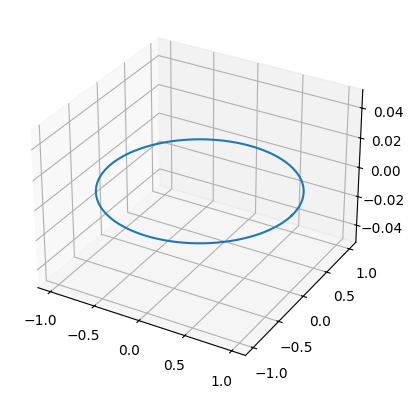

(100, 3)

In [3]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

Now let's get our second input: the Lorenz attractor

In [4]:
xyz = dl.make_lorenz()

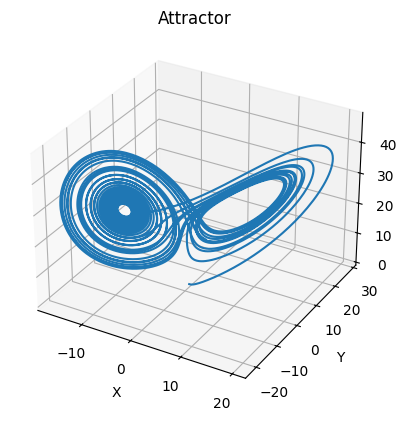

In [5]:
dl.plot_lorenz(xyz)

In [19]:
# reshape it for use with cebra
new_lorenz = np.transpose(xyz)
new_lorenz.shape

(10000, 3)

## Fixed Temperature Model:

In [7]:
iterations = 2000

In [24]:
# function to get an embedding    
def base_embed(input, temp=1, dimension=3, lr = 0.01):
# build CEBRA time model

    fixed_temp_model = CEBRA(model_architecture='offset1-model-mse',
                            batch_size=512,
                            learning_rate=int(lr),
                            temperature=int(temp),
                            output_dimension = int(dimension),
                            max_iterations=iterations,
                            delta=0.1,
                            distance='euclidean',
                            conditional='time',
                            device='cuda_if_available',
                            num_hidden_units=64,
                            verbose=True)

    train_size = int((input.shape[0])*0.8)    
    fixed_temp_model.fit(input[:train_size])
    embedding = fixed_temp_model.transform(input)
    return fixed_temp_model, embedding

In [21]:
# get the embeddings
ft_model_c, ft_embedding_c = base_embed(circle, lr=0.1)
ft_model_l, ft_embedding_l = base_embed(new_lorenz, lr=0.01)

pos:  0.0000 neg:  6.2380 total:  6.2380 temperature:  1.0000: 100%|██████████| 2000/2000 [00:09<00:00, 208.01it/s]
pos:  0.0002 neg:  5.9349 total:  5.9351 temperature:  1.0000: 100%|██████████| 2000/2000 [00:09<00:00, 207.02it/s]


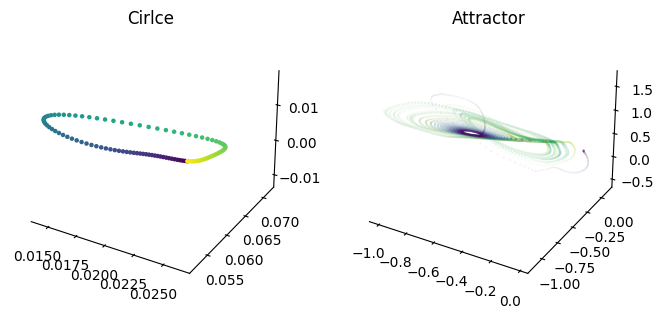

In [22]:
# plot the embeddings
dl.plot_2embeddings(ft_embedding_c,ft_embedding_l)

## Learnable temperature model

Setting temperature_mode to auto will make the temperature to be optimized during the training of a model.

min_temperature is the lower bound for the tempearture. If not specified, min_temperature is set to asymptotic 0. (from CEBRA documentation)

In [25]:
# function to get an embedding    
def base_embed_l(input, temp=1, dimension=3, lr = 0.01):
# build CEBRA time model
    fixed_temp_model = CEBRA(model_architecture='offset1-model',
                            batch_size=512,
                            learning_rate=int(lr),
                            temperature_mode='auto',
                            min_temperature=0.1,
                            delta=0.1,
                            output_dimension = int(dimension),
                            max_iterations=iterations,
                            distance='euclidean',
                            conditional='time',
                            device='cuda_if_available',
                            num_hidden_units=64,
                            verbose=True)

    train_size = int((input.shape[0])*0.8)    
    fixed_temp_model.fit(input[:train_size])
    embedding = fixed_temp_model.transform(input)
    return fixed_temp_model, embedding

In [26]:
# get the embeddings
lt_model_c, lt_embedding_c = base_embed_l(circle, lr=0.1)
lt_model_l, lt_embedding_l = base_embed_l(new_lorenz, lr=0.01)

pos:  0.0001 neg:  6.2177 total:  6.2178 temperature:  1.0000: 100%|██████████| 2000/2000 [00:10<00:00, 188.93it/s]
pos:  0.0001 neg:  5.9171 total:  5.9172 temperature:  1.0000: 100%|██████████| 2000/2000 [00:10<00:00, 190.00it/s]


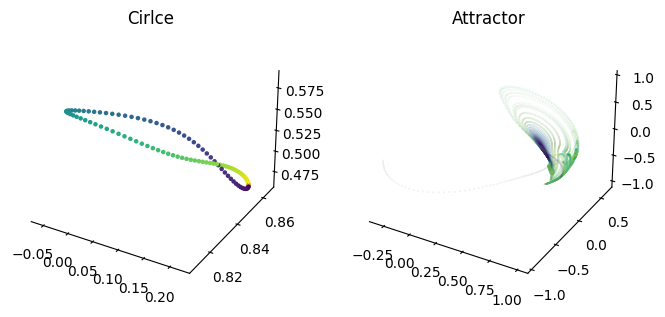

In [27]:
# plot the embeddings
dl.plot_2embeddings(lt_embedding_c,lt_embedding_l)

In [16]:
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

In [43]:
# define the save directory
results_folder = '/root/capsule/results'
temp_comparison_folder = 'temp_comparison'
save_dir = os.path.join(results_folder, temp_comparison_folder)
os.makedirs(save_dir, exist_ok=True)

## Reconstruction scores

Evaluate the fixed temperature model first. Run several iterations and record the mean score.

In [45]:
def fixed_temp_evaluation(n_iterations=2):

    # define grid
    fig0 = plt.figure(figsize=(8,4*n_iterations))
    gs = gridspec.GridSpec(n_iterations, 2, figure=fig0)

    # fixed temp scores
    fixed_temp_scores = []

    # keep track of best embedding and best score
    champion_score = 0
    best_embedding = None

    # for each iteration
    for i in range(0,n_iterations):

        # create models and compute embeddings
        model_c, embedding_c = base_embed(circle, lr=0.1)
        model_l, embedding_l = base_embed(new_lorenz, lr=0.01)

        score, t_embedding_ = reconstruction_score(embedding_l, new_lorenz)
        fixed_temp_scores.append(score)

        # plot the embeddings
        ax0 = fig0.add_subplot(gs[i,0], projection='3d')
        ax1 = fig0.add_subplot(gs[i,1], projection='3d')
        cebra.plot_embedding(embedding_c, embedding_labels='time', ax=ax0, markersize=5, alpha=1, title='Circle')
        cebra.plot_embedding(embedding_l, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title=f'Lorenz Attractor: {np.round(score,3)}')


        # update the champion score and embedding
        if score > champion_score:
            champion_score = score
            best_embedding = t_embedding_


    # record mean score in title
    mean_score = np.round(np.mean(fixed_temp_scores),3)

    # plot the best embedding (transformed version)

    # Add title and save it
    fig0.suptitle('Fixed temperature, mean score: {}'.format(mean_score))
    plt.savefig(save_dir + os.sep + "Fixed Temp embeddings" + ".png")
    plt.close(fig0)

    # return the best embedding (transformed version)
    
    return best_embedding

In [46]:
ft_t_embed = fixed_temp_evaluation()

pos:  0.0000 neg:  6.2381 total:  6.2381 temperature:  1.0000: 100%|██████████| 2000/2000 [00:10<00:00, 183.84it/s]
pos:  0.0002 neg:  5.9751 total:  5.9753 temperature:  1.0000: 100%|██████████| 2000/2000 [00:10<00:00, 183.63it/s]
pos:  0.0000 neg:  6.2380 total:  6.2380 temperature:  1.0000: 100%|██████████| 2000/2000 [00:10<00:00, 182.59it/s]
pos:  0.0002 neg:  5.8762 total:  5.8765 temperature:  1.0000: 100%|██████████| 2000/2000 [00:10<00:00, 182.36it/s]


Now do the same for the learnable temperature models.

In [47]:
def learnable_temp_evaluation(n_iterations=2):

    # define grid
    fig0 = plt.figure(figsize=(8,4*n_iterations))
    gs = gridspec.GridSpec(n_iterations, 2, figure=fig0)

    # fixed temp scores
    learnable_temp_scores = []

    # keep track of best embedding and best score
    champion_score = 0
    best_embedding = None

    # for each iteration
    for i in range(0,n_iterations):

        # create models and compute embeddings
        lt_model_c, lt_embedding_c = base_embed_l(circle, lr=0.1)
        lt_model_l, lt_embedding_l = base_embed_l(new_lorenz, lr=0.01)

        score, t_embedding_ = reconstruction_score(lt_embedding_l, new_lorenz)
        learnable_temp_scores.append(score)

        # plot the embeddings
        ax0 = fig0.add_subplot(gs[i,0], projection='3d')
        ax1 = fig0.add_subplot(gs[i,1], projection='3d')
        cebra.plot_embedding(lt_embedding_c, embedding_labels='time', ax=ax0, markersize=5, alpha=1, title='Circle')
        cebra.plot_embedding(lt_embedding_l, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title=f'Lorenz Attractor: {np.round(score,3)}')

        # update the champion score and embedding
        if score > champion_score:
            champion_score = score
            best_embedding = t_embedding_

    # record mean score in title
    mean_score = np.round(np.mean(learnable_temp_scores),3)

    # Add title and save it
    fig0.suptitle('Learnable temperature, mean score: {}'.format(mean_score))
    plt.savefig(save_dir + os.sep + "Learnable Temp embeddings" + ".png")
    plt.close(fig0)
    
    # return the best embedding (transformed version)

    return best_embedding

In [48]:
best_t_embed_l = learnable_temp_evaluation()

pos:  0.0003 neg:  6.1261 total:  6.1264 temperature:  1.0000: 100%|██████████| 2000/2000 [00:16<00:00, 122.08it/s]
pos:  0.0001 neg:  6.1314 total:  6.1314 temperature:  1.0000: 100%|██████████| 2000/2000 [00:16<00:00, 124.26it/s]
pos:  0.0000 neg:  6.2281 total:  6.2281 temperature:  1.0000: 100%|██████████| 2000/2000 [00:16<00:00, 123.34it/s]
pos:  0.0002 neg:  5.7698 total:  5.7700 temperature:  1.0000: 100%|██████████| 2000/2000 [00:16<00:00, 122.14it/s]


<Axes: xlabel='Steps', ylabel='Temperature'>

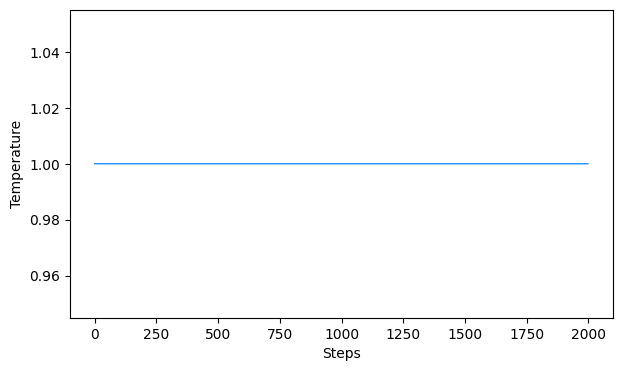

In [50]:
cebra.plot_temperature(lt_model_l)